In [1]:
import pandas as pd

df = pd.read_csv('gs://vtx-datasets-public/breast_cancer_data.csv')
df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [22]:
## Create request

package = df.iloc[1,:-1].to_list()
package

[20.57, 17.77, 132.9, 1326.0, 0.08474]

In [9]:
## Model Location

!gsutil ls gs://vtx-models/lightgbm

gs://vtx-models/lightgbm/model.pkl


In [11]:
from google.cloud import storage
import pickle

client = storage.Client(project='jchavezar-demo')
with open('model.pkl', 'wb') as model:
    client.download_blob_to_file('gs://vtx-models/lightgbm/model.pkl', model)

with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

/home/jesusarguelles/.local/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.0.2 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [23]:
x = {"instances": [package]}
x

{'instances': [[20.57, 17.77, 132.9, 1326.0, 0.08474]]}

In [24]:
print(x["instances"])

[[20.57, 17.77, 132.9, 1326.0, 0.08474]]


In [25]:
model.predict(x['instances'])

array([0])

## Testing Input and Outputs VTX Components

In [12]:
VTX_ROOT_PATH = 'gs://vtx-root-path'
IMAGE_URI = 'gcr.io/jchavezar-demo/custom_train_draft:v1'

In [2]:
!rm -fr custom_train_draft
!mkdir custom_train_draft
!mkdir custom_train_draft/trainer

In [65]:
%%writefile custom_train_draft/trainer/train.py

import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--test', dest='test', help='testing')
args = parser.parse_args()

print(args.test)
with open(args.test, 'r') as f:
    x = f.read()
print(x)

Overwriting custom_train_draft/trainer/train.py


In [66]:
%%writefile custom_train_draft/Dockerfile

FROM python:latest

COPY trainer/ /trainer

ENTRYPOINT ["python", "-m", "trainer.train"]

Overwriting custom_train_draft/Dockerfile


In [67]:
!gcloud builds submit -t $IMAGE_URI custom_train_draft/.

Creating temporary tarball archive of 2 file(s) totalling 304 bytes before compression.
Uploading tarball of [custom_train_draft/.] to [gs://jchavezar-demo_cloudbuild/source/1662352067.455567-41f58f62c4814fa381aea506a0821cc5.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/f8ddddee-243a-4d9a-a366-42d4a2cce368].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/f8ddddee-243a-4d9a-a366-42d4a2cce368?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "f8ddddee-243a-4d9a-a366-42d4a2cce368"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1662352067.455567-41f58f62c4814fa381aea506a0821cc5.tgz#1662352067848600
Copying gs://jchavezar-demo_cloudbuild/source/1662352067.455567-41f58f62c4814fa381aea506a0821cc5.tgz#1662352067848600...
/ [1 files][  385.0 B/  385.0 B]                                                
Operation compl

In [68]:
from kfp.v2.dsl import component, Input, Output, Artifact

@component
def dataset(test: Output[Artifact]):
    with open(test.path, 'w') as f:
        f.write('test_inside')

In [69]:
from typing import NamedTuple

@component
def create_worker(
    input: Input[Artifact],
    image_uri: str
)-> NamedTuple(
    "Outputs", 
    [("workerpoolspec", list)]
):
    print(input)
    print(input.path)
    print(type(input))
    print(dir(input))
    worker_pool_specs = [{
        "machine_spec": {
        "machine_type": "n1-standard-4"
        },
        "replica_count": "1",
        "container_spec": {
            "image_uri": image_uri,
            "args": ["--test", input.path]
        }
    }]

    from collections import namedtuple
    output = namedtuple('Outputs', ['workerpoolspec'])
    
    return output(worker_pool_specs)

    print(input)

In [70]:
from kfp.v2.dsl import pipeline
from google_cloud_pipeline_components.v1.custom_job import CustomTrainingJobOp


@pipeline(name='test')
def pipeline():
    dataset_job = dataset()
    construct_workerpool_spec = create_worker(
        dataset_job.outputs['test'],
        image_uri=IMAGE_URI
        )
    train_job = CustomTrainingJobOp(
        project="jchavezar-demo",
        display_name="testing-disp",
        worker_pool_specs=construct_workerpool_spec.outputs['workerpoolspec']

    )

In [71]:
from kfp.v2 import compiler
import warnings
warnings.filterwarnings('ignore')

compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='custom_train_draft.json')

In [72]:
import google.cloud.aiplatform as aip

job = aip.PipelineJob(
    display_name="custom_train_draft",
    template_path="custom_train_draft.json",
    pipeline_root=VTX_ROOT_PATH,
    parameter_values={
    },
)

job.submit()

Creating PipelineJob
PipelineJob created. Resource name: projects/569083142710/locations/us-central1/pipelineJobs/test-20220905002825
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/569083142710/locations/us-central1/pipelineJobs/test-20220905002825')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/test-20220905002825?project=569083142710


## CustomTrainingJobOp

In [101]:
from kfp.v2.dsl import component

@component(
    packages_to_install=[
        'tensorflow', 
        'pandas',
        'gcsfs',
        'fsspec']
)
def data_create(dataset_uri: str):
    from tensorflow import keras
    import pandas as pd

    dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
    column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
    dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)
    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
    train_dataset = dataset.sample(frac=0.8,random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("MPG")
    train_stats = train_stats.transpose()

    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')

    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)
    
    normed_train_data.to_csv(f"{dataset_uri}.train_data.csv", index=False)
    normed_test_data.to_csv(f"{dataset_uri}.test_data.csv", index=False)


### Create Training Code

In [102]:
VTX_ROOT_PATH = 'gs://vtx-root-path'
IMAGE_URI = 'gcr.io/jchavezar-demo/custom_train_draft:v2'

In [103]:
!rm -fr custom_train_draft
!mkdir custom_train_draft
!mkdir custom_train_draft/trainer

In [104]:
%%writefile custom_train_draft/trainer/train.py

import argparse
import pandas as pd

parser = argparse.ArgumentParser()
parser.add_argument('--dataset_uri', dest='dataset_uri', help='testing')
args = parser.parse_args()

print(args.dataset_uri)

normed_train_data = pd.read_csv(f"{args.dataset_uri}.train_data.csv")
normed_test_data = pd.read_csv(f"{args.dataset_uri}.test_data.csv")

print(normed_train_data)

Writing custom_train_draft/trainer/train.py


In [105]:
%%writefile custom_train_draft/Dockerfile

FROM python:latest

RUN pip install pandas \
    && pip install gcsfs \
    && pip install fsspec

COPY trainer/ /trainer

ENTRYPOINT ["python", "-m", "trainer.train"]

Writing custom_train_draft/Dockerfile


In [106]:
!gcloud builds submit -t $IMAGE_URI custom_train_draft/.

Creating temporary tarball archive of 2 file(s) totalling 532 bytes before compression.
Uploading tarball of [custom_train_draft/.] to [gs://jchavezar-demo_cloudbuild/source/1662354160.095494-4ec188779091451bba97b0c32e47c23b.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/b671b45e-c8c7-4b4e-b8d2-f4fe113c0424].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/b671b45e-c8c7-4b4e-b8d2-f4fe113c0424?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "b671b45e-c8c7-4b4e-b8d2-f4fe113c0424"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1662354160.095494-4ec188779091451bba97b0c32e47c23b.tgz#1662354160618675
Copying gs://jchavezar-demo_cloudbuild/source/1662354160.095494-4ec188779091451bba97b0c32e47c23b.tgz#1662354160618675...
/ [1 files][  452.0 B/  452.0 B]                                                
Operation compl

In [113]:
IMAGE_URI

'gcr.io/jchavezar-demo/custom_train_draft:v2'

In [120]:
from kfp.v2.dsl import pipeline
from google_cloud_pipeline_components.v1.custom_job import CustomTrainingJobOp


@pipeline(name='test-2')
def pipeline():
    data_create_job = data_create('gs://vtx-datasets-public/mpg-custom/')
    train_job = CustomTrainingJobOp(
        project="jchavezar-demo",
        display_name="testing-disp",
        worker_pool_specs=[{
            "machine_spec": {
                "machine_type": "n1-standard-4"
            },
            "replica_count": "1",
            "container_spec": {
                "image_uri": IMAGE_URI,
                "args": ["--dataset_uri", "gs://vtx-datasets-public/mpg-custom/"]
            }
        }]
    ).after(data_create_job)

In [121]:
from kfp.v2 import compiler
import warnings
warnings.filterwarnings('ignore')

compiler.Compiler().compile(pipeline_func=pipeline,
        package_path='custom_train_draft_2.json')

In [122]:
import google.cloud.aiplatform as aip

job = aip.PipelineJob(
    display_name="custom_train_draft_2",
    template_path="custom_train_draft_2.json",
    pipeline_root=VTX_ROOT_PATH,
    parameter_values={
    },
)

job.submit()

Creating PipelineJob
PipelineJob created. Resource name: projects/569083142710/locations/us-central1/pipelineJobs/test-2-20220905012601
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/569083142710/locations/us-central1/pipelineJobs/test-2-20220905012601')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/test-2-20220905012601?project=569083142710


## Analyzing

In [158]:
from tensorflow import keras
import pandas as pd

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

In [159]:
dataset = raw_dataset.copy()
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [160]:
    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')

In [161]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1


In [162]:
    train_dataset = dataset.sample(frac=0.8,random_state=0)
    test_dataset = dataset.drop(train_dataset.index)

    train_stats = train_dataset.describe()
    train_stats.pop("MPG")
    train_stats = train_stats.transpose()

In [163]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [164]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [165]:
    train_stats = train_dataset.describe()
    train_stats.pop("MPG")
    train_stats = train_stats.transpose()
    train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [143]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [150]:
train_stats = train_stats.transpose()

In [166]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [167]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [170]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [172]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_datab = norm(train_dataset)
normed_test_data = norm(test_dataset)
    
#normed_train_data.to_csv(f"{dataset_uri}.train_data.csv", index=False)
#normed_test_data.to_csv(f"{dataset_uri}.test_data.csv", index=False)

In [193]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751


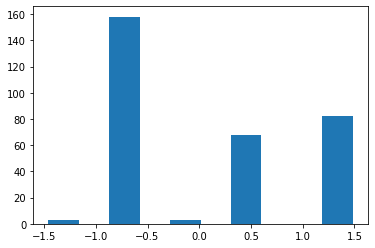

In [187]:
import matplotlib.pyplot as plt
plt.hist(normed_train_data['Cylinders'], bins=10)
plt.show()

In [205]:
def pre_process(dataset):
    import pandas as pd

    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    train_stats = train_dataset.describe()
    train_stats.pop('MPG')
    train_stats = train_stats.transpose()
    train_stats.to_csv('stats.csv')
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    def norm(x):
        return (x - train_stats['mean'])/train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, normed_test_data

In [206]:
from tensorflow import keras
import pandas as pd

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

train, test = pre_process(dataset)

/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [207]:
train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,-0.465148,-0.495225,0.774676
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,-0.465148,-0.495225,0.774676
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,-0.465148,-0.495225,0.774676
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,-0.465148,-0.495225,0.774676
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-0.465148,2.012852,-1.286751
...,...,...,...,...,...,...,...,...,...
281,0.307270,0.044872,-0.521559,-0.000298,0.946772,0.843910,-0.465148,-0.495225,0.774676
229,1.483887,1.961837,1.972127,1.457223,-1.598734,0.299787,-0.465148,-0.495225,0.774676
150,-0.869348,-0.836932,-0.311564,-0.710099,-0.021237,-0.516397,-0.465148,2.012852,-1.286751
145,-0.869348,-1.076553,-1.151543,-1.169870,1.233589,-0.516397,-0.465148,2.012852,-1.286751


In [54]:
x=train.iloc[1,:].tolist()

def post_process(data: list):
    import pandas as pd
    
    column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Europe', 'Japan', 'USA']

    dataset = pd.DataFrame([data], columns=column_names)
    
    def denorm(dataset):
        stats = pd.read_csv('stats.csv')
        return (dataset*stats['std'].values)+stats['mean'].values

    return denorm(dataset)

post_process(x)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,4.0,140.0,88.0,2890.0,17.3,79.0,-5.551115e-17,-2.775558e-17,1.0


In [61]:
pd.get_dummies(dataset['Origin'].map({1:'USA', 2:'Europe', 3:'Japan'}))

,Europe,Japan,USA
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
393,0,0,1
394,1,0,0
395,0,0,1
396,0,0,1


In [9]:
def pred_data_process(data: list):
    import pandas as pd
    
    column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
    dataset = pd.DataFrame([data], columns=column_names)

    dataset = dataset.dropna()
    #dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    #dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')


    if (dataset['Origin'] == 1).any():
        dataset = dataset.drop(columns=['Origin'])
        dataset['Europe'] = 0
        dataset['Japan'] = 0
        dataset['USA'] = 1

    elif (dataset['Origin'].any == 2).any():
        dataset = dataset.drop(columns=['Origin'])
        dataset['Europe'] = 1
        dataset['Japan'] = 0
        dataset['USA'] = 0

    elif (dataset['Origin'] == 3).any():
        dataset = dataset.drop(columns=['Origin'])
        dataset['Europe'] = 0
        dataset['Japan'] = 1
        dataset['USA'] = 0

    ## Train stats

    train_stats = pd.read_csv('stats.csv', index_col=[0])
    
    def norm(x):
        return (x - train_stats['mean'])/train_stats['std']
    normed_data = norm(dataset)

    return normed_data

In [29]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

x=dataset.iloc[1,1:].tolist()
x

NameError: name 'keras' is not defined

In [10]:
dataset = pred_data_process(x)

In [198]:
dataset

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,1.483887,1.482595,1.578387,0.83274,-1.455325,-1.604642,-0.465148,-0.495225,0.774676


In [202]:
x

[8.0, 350.0, 165.0, 3693.0, 11.5, 70.0, 1.0]

In [1]:
!rm -fr custom_pred_draft
!mkdir custom_pred_draft
!mkdir custom_pred_draft/app

In [2]:
%%writefile custom_pred_draft/app/main.py

from fastapi import Request, FastAPI
from tensorflow import keras
import json
import os

app = FastAPI()

@app.get('/')
def get_root():
    return {'message': 'Welcome mpg API: miles per gallon prediction'}

@app.get('/health_check')
def health():
    return 200

if os.environ.get('AIP_PREDICT_ROUTE') is not None:
    method = os.environ['AIP_PREDICT_ROUTE']
else:
    method = '/predict'

@app.post(method)
async def predict(request: Request):
    print("----------------- PREDICTING -----------------")
    body = await request.json()
    instances = body["instances"]

    def pred_data_process(data: list):
        import pandas as pd
    
        column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']
        dataset = pd.DataFrame([data], columns=column_names)

        dataset = dataset.dropna()
        #dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
        #dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')


        if (dataset['Origin'] == 1).any():
            dataset = dataset.drop(columns=['Origin'])
            dataset['Europe'] = 0
            dataset['Japan'] = 0
            dataset['USA'] = 1

        elif (dataset['Origin'].any == 2).any():
            dataset = dataset.drop(columns=['Origin'])
            dataset['Europe'] = 1
            dataset['Japan'] = 0
            dataset['USA'] = 0

        elif (dataset['Origin'] == 3).any():
            dataset = dataset.drop(columns=['Origin'])
            dataset['Europe'] = 0
            dataset['Japan'] = 1
            dataset['USA'] = 0

        ## Train stats

        train_stats = pd.read_csv('stats.csv', index_col=[0])
    
        def norm(x):
            return (x - train_stats['mean'])/train_stats['std']
        normed_data = norm(dataset)

        return normed_data
    
    norm_data = pred_data_process(instances)
    outputs = model.predict(norm_data)
    response = outputs.tolist()
    print("----------------- OUTPUTS -----------------")
    return {"predictions": response}


Writing custom_pred_draft/app/main.py


In [2]:
## Variables

MODEL_URI = 'gs://vtx-models'

In [7]:
## Preprocess data for training: 

def pre_process(dataset):
    import pandas as pd

    dataset = dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    train_stats = train_dataset.describe()
    train_stats.pop('MPG')
    train_stats = train_stats.transpose()
    train_stats.to_csv(f'{MODEL_URI}/mpg/stats.csv')
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    def norm(x):
        return (x - train_stats['mean'])/train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)

    return normed_train_data, train_labels, normed_test_data, test_labels

In [22]:
from tensorflow import keras
import pandas as pd

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

train_data, train_labels, test_data, test_labels = pre_process(dataset)

/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [24]:
## Train data

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_model(train_dataset):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
        optimizer=optimizer,
        metrics=['mae', 'mse'])
    
    return model

def train_model(train_data, train_labels, epochs: int = 1000):
    model = build_model(train_data)
    epochs = epochs
    
    # The patience parameter is the amount of epochs to check for improvement
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    
    early_history = model.fit(train_data, train_labels, 
        epochs=epochs, validation_split = 0.2, 
        callbacks=[early_stop])
    
    model.save(f'{MODEL_URI}/mpg/model')

train_model(train_data, train_labels)

Epoch 1/1000
8/8 [==============================] - 1s 16ms/step - loss: 534.1863 - mae: 21.8042 - mse: 534.1863 - val_loss: 509.3176 - val_mae: 21.2353 - val_mse: 509.3176
Epoch 2/1000
8/8 [==============================] - 0s 3ms/step - loss: 463.1268 - mae: 20.1906 - mse: 463.1268 - val_loss: 437.0307 - val_mae: 19.5309 - val_mse: 437.0307
Epoch 3/1000
8/8 [==============================] - 0s 3ms/step - loss: 398.0106 - mae: 18.5836 - mse: 398.0106 - val_loss: 367.7173 - val_mae: 17.7414 - val_mse: 367.7173
Epoch 4/1000
8/8 [==============================] - 0s 4ms/step - loss: 333.6395 - mae: 16.8588 - mse: 333.6395 - val_loss: 297.9839 - val_mae: 15.7608 - val_mse: 297.9839
Epoch 5/1000
8/8 [==============================] - 0s 3ms/step - loss: 269.8069 - mae: 14.9733 - mse: 269.8069 - val_loss: 231.0945 - val_mae: 13.6563 - val_mse: 231.0945
Epoch 6/1000
8/8 [==============================] - 0s 3ms/step - loss: 209.3784 - mae: 13.0100 - mse: 209.3784 - val_loss: 171.2802 - val_

In [5]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

model = tf.keras.models.load_model(f'{MODEL_URI}/mpg/model')

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

x=dataset.iloc[1,1:].tolist()

In [11]:
data_set = pred_data_process(x)
model.predict(data_set)

1/1 [==============================] - 0s 151ms/step


array([[-0.28936613]], dtype=float32)

In [12]:
x

[8.0, 350.0, 165.0, 3693.0, 11.5, 70.0, 1.0]

In [30]:
## Predictions

import tensorflow as tf

model = tf.keras.models.load_model(f'{MODEL_URI}/mpg/model')

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

x=dataset.iloc[1,1:].tolist()
data_set = pred_data_process(x)

model.predict(data_set)

2022-09-12 09:52:20.167756: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-12 09:52:20.175392: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 09:52:20.175403: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


NameError: name 'MODEL_URI' is not defined

In [37]:
x=dataset.iloc[1,:]
x

MPG               15.0
Cylinders          8.0
Displacement     350.0
Horsepower       165.0
Weight          3693.0
Acceleration      11.5
Model Year        70.0
Origin             1.0
Name: 1, dtype: float64

In [31]:
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt

dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?", comment='\t',sep=" ", skipinitialspace=True)


#for n,col in enumerate(dataset.columns):

<AxesSubplot:title={'center':'Histogram of MPG'}, ylabel='Frequency'>

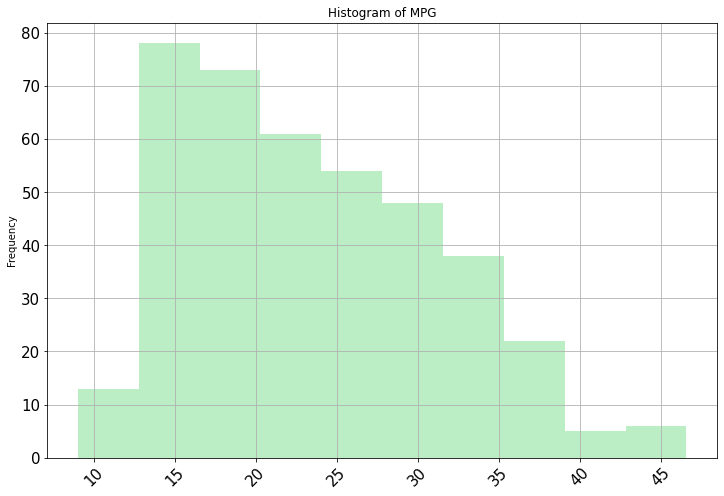

In [8]:
bplt.figure()
dataset['MPG'].plot(
    kind='hist',
    alpha=0.7, 
    title=f'Histogram of {dataset.columns[0]}', 
    rot=45,
    grid=True,
    figsize=(12,8),
    fontsize=15,
    color=['#A0E8AF'])

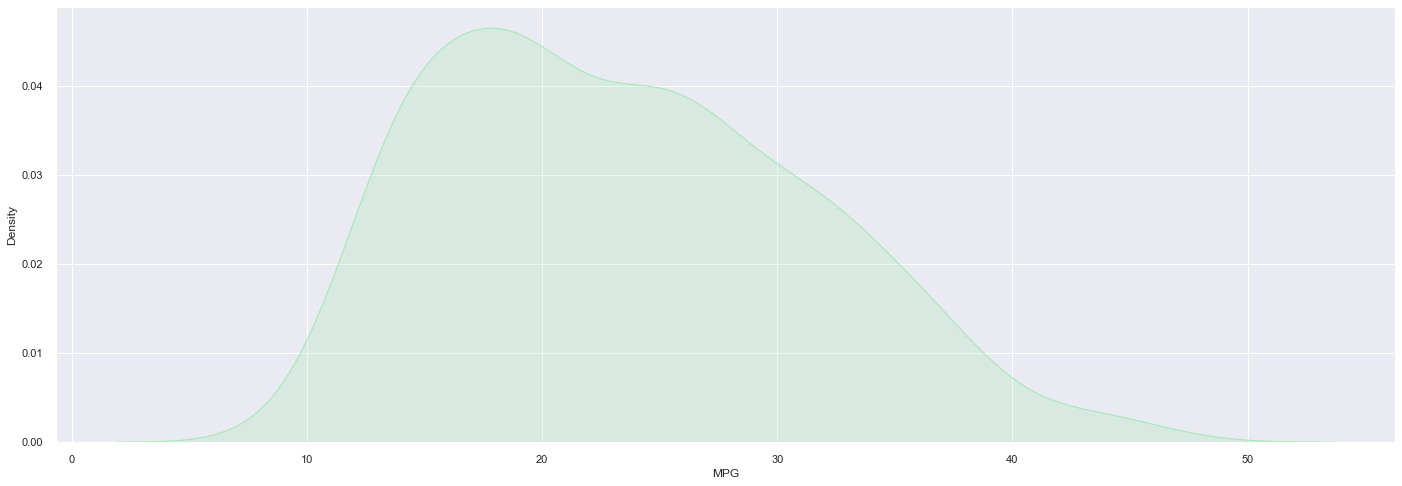

In [56]:
plt.figure(figsize=(24,8))
sns.kdeplot(data=dataset['MPG'], color=['#A0E8AF'],shade=True, legend='test')
plt.show()

In [81]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Skew : 0.01


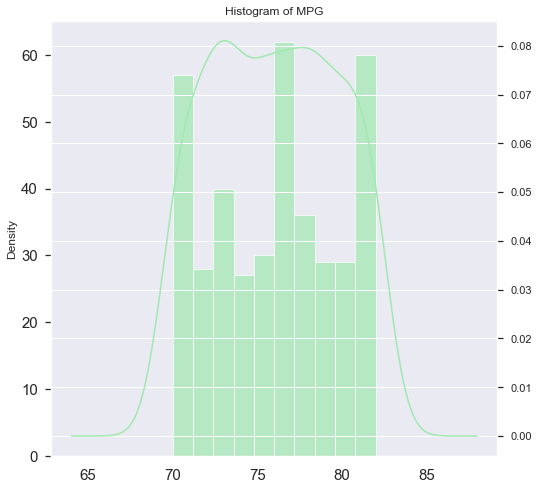

In [83]:
print('Skew :', round(dataset['Model Year'].skew(),2))
ax = dataset['Model Year'].plot(
    kind='hist',
    alpha=0.7, 
    title=f'Histogram of {dataset.columns[0]}', 
    rot=45,
    grid=True,
    figsize=(8,8),
    fontsize=15,
    color=['#A0E8AF'])
dataset['Model Year'].plot(kind='kde', ax=ax, secondary_y=True)
plt.show()

<AxesSubplot:title={'center':'Histogram of MPG'}, ylabel='Frequency'>

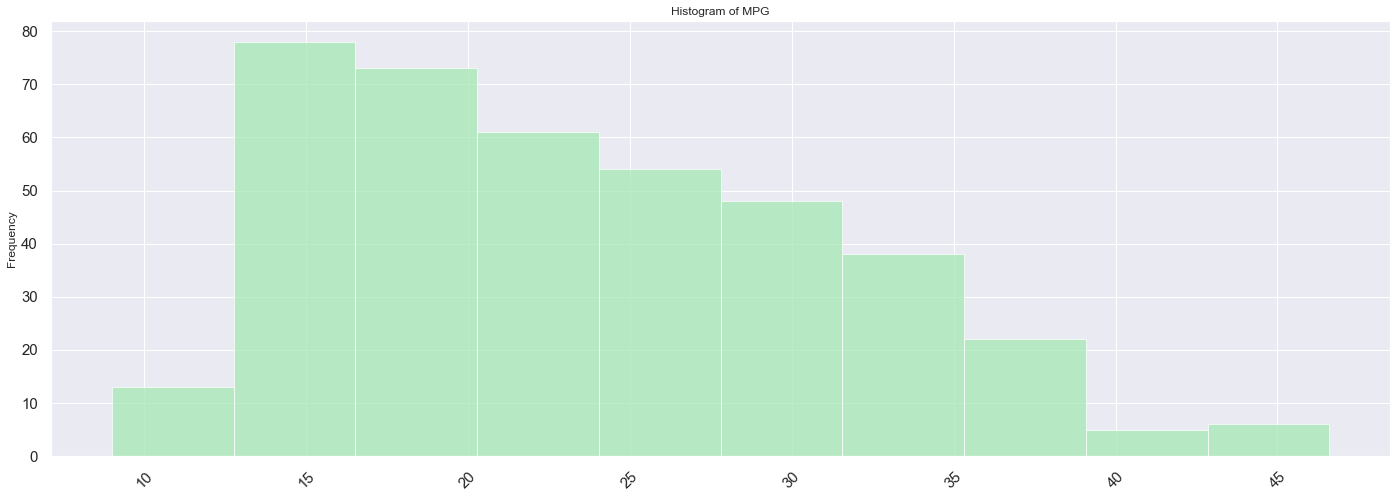

In [35]:
plt.figure(figsize=(24,8))
dataset['MPG'].plot(
    kind='hist',
    alpha=0.7, 
    title=f'Histogram of MPG', 
    rot=45,
    grid=True,
    figsize=(24,8),
    fontsize=15,
    color=['#A0E8AF']
)

MPG
Skew : 0.46


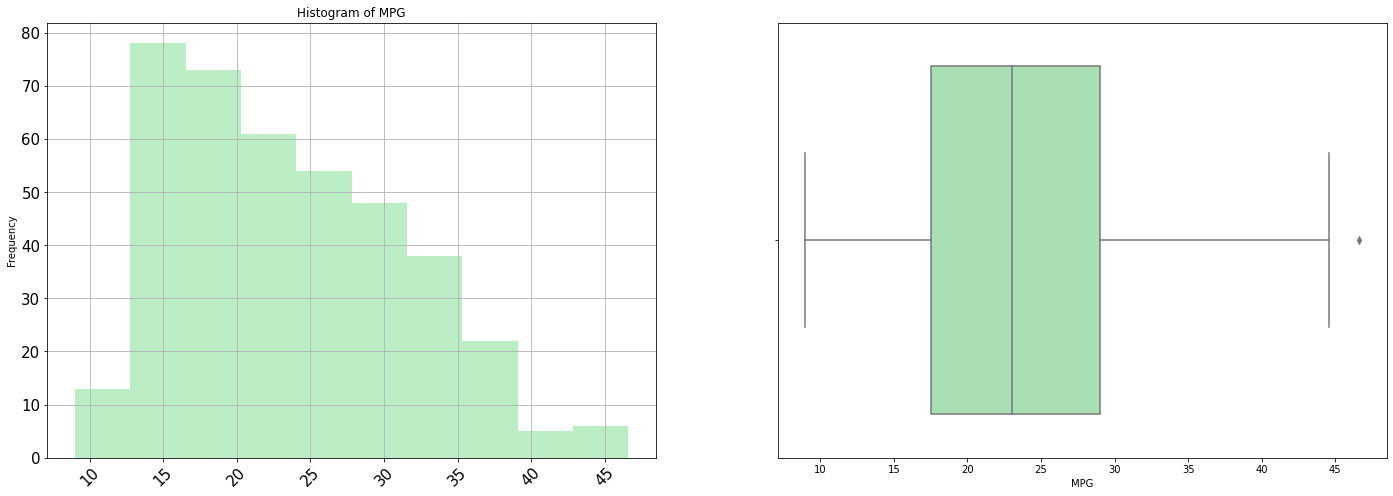

Cylinders
Skew : 0.53


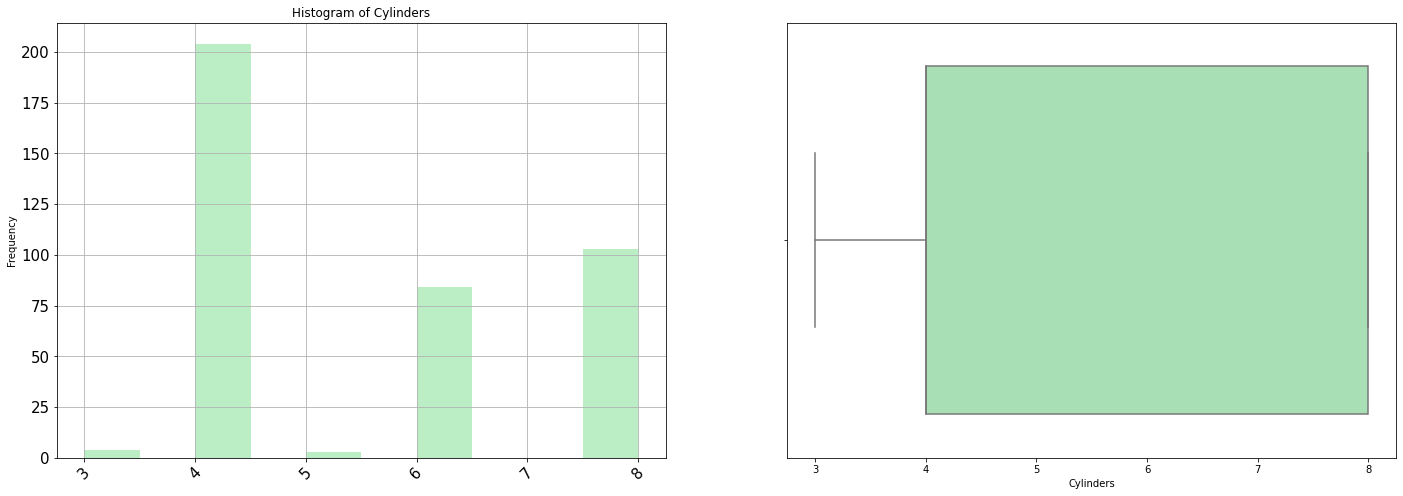

Displacement
Skew : 0.72


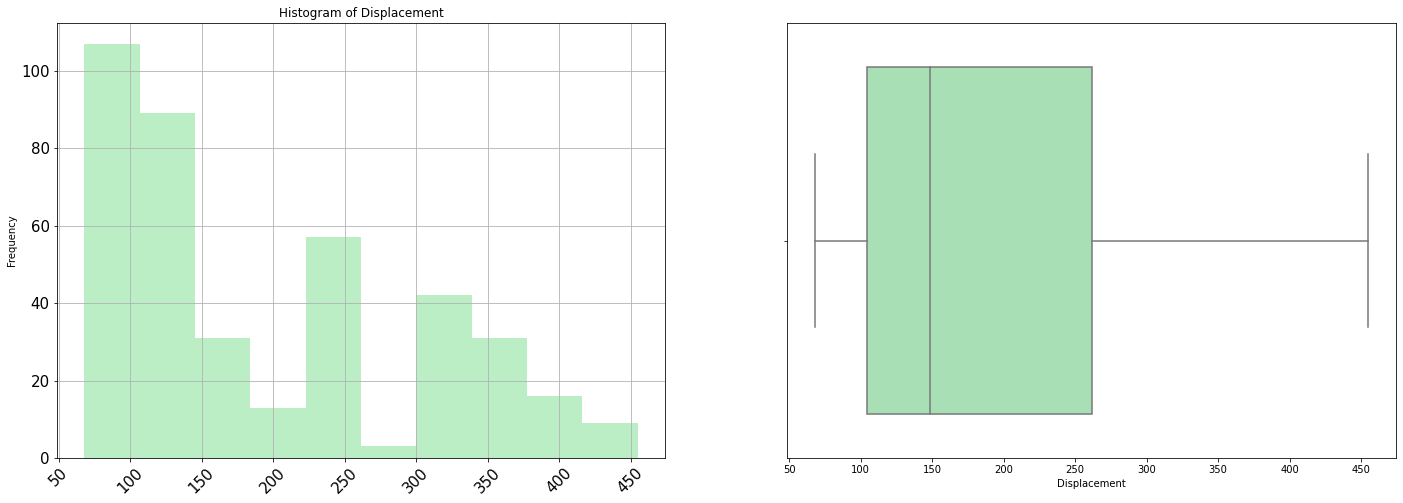

Horsepower
Skew : 1.09


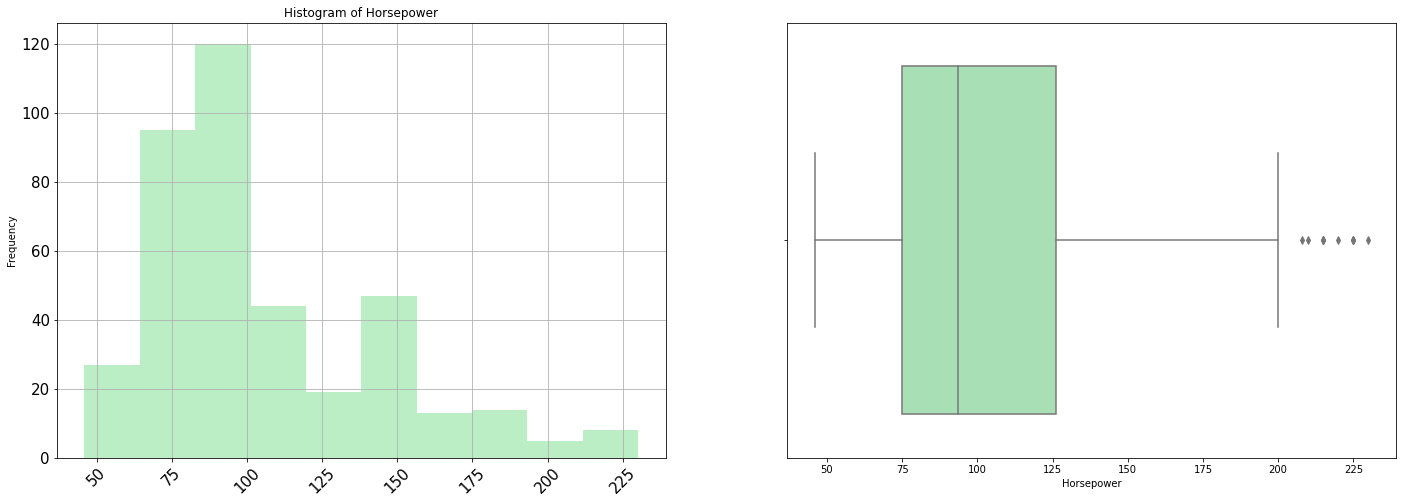

Weight
Skew : 0.53


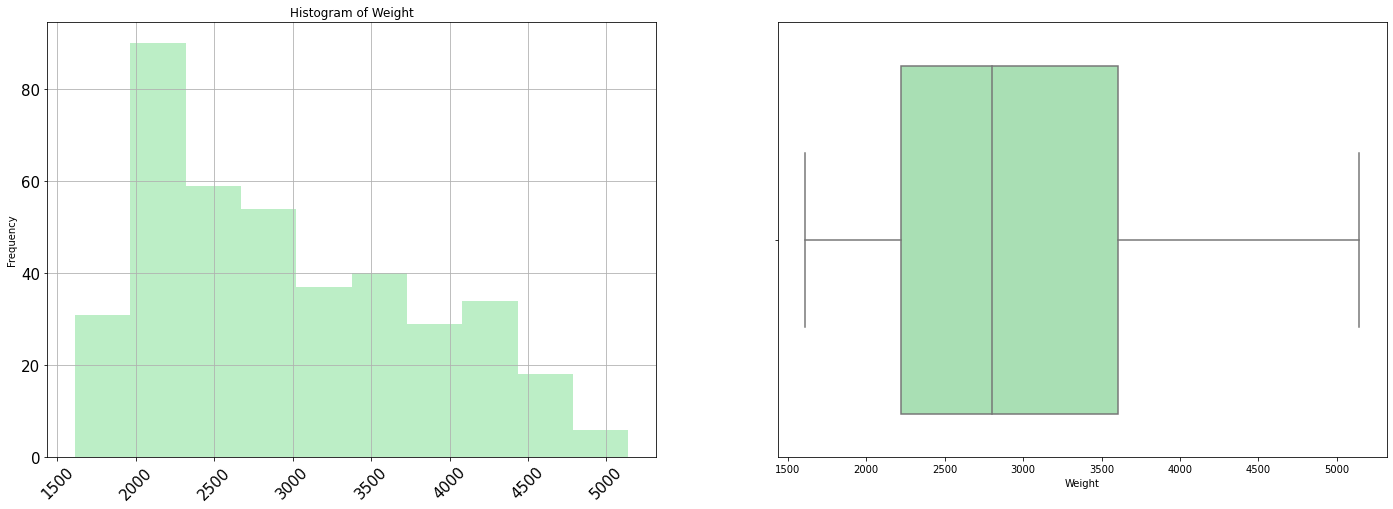

Acceleration
Skew : 0.28


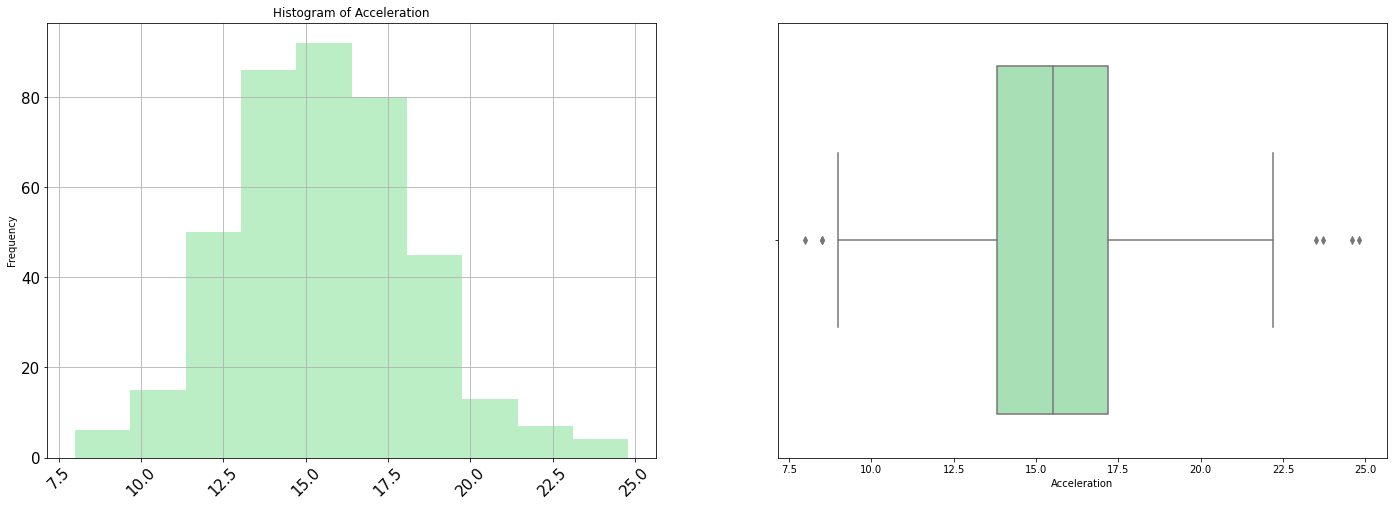

Model Year
Skew : 0.01


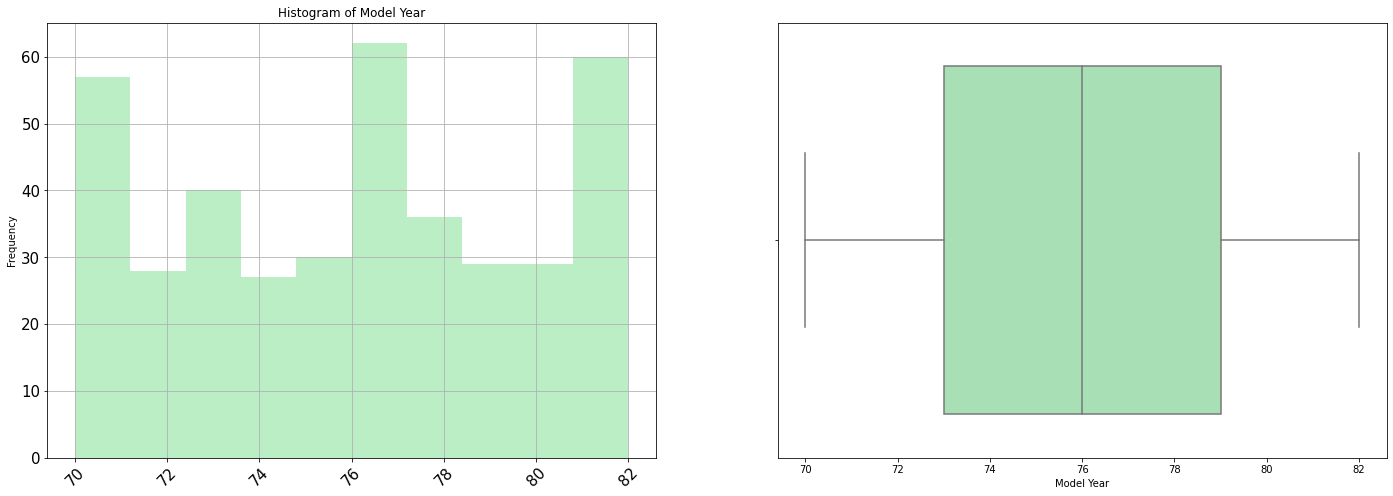

Origin
Skew : 0.92


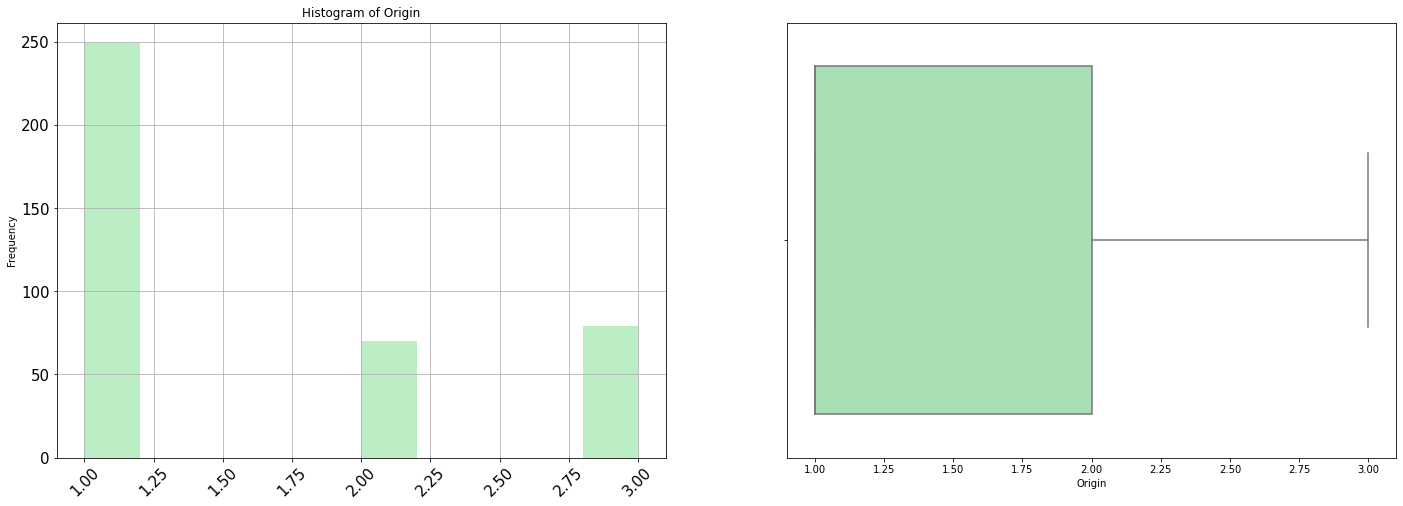

In [74]:
import seaborn as sns

for i in dataset.columns:
    print(i)
    print('Skew :', round(dataset[i].skew(),2))
    plt.figure(figsize=(24,8))
    plt.subplot(1,2,1)
    dataset[i].plot(
        kind='hist',
        alpha=0.7, 
        title=f'Histogram of {i}', 
        rot=45,
        grid=True,
        figsize=(24,8),
        fontsize=15,
        color=['#A0E8AF']
    )
    plt.subplot(1,2,2)
    sns.set_palette(sns.color_palette(["#A0E8AF"]))
    sns.boxplot(x=dataset[i])
    plt.show()

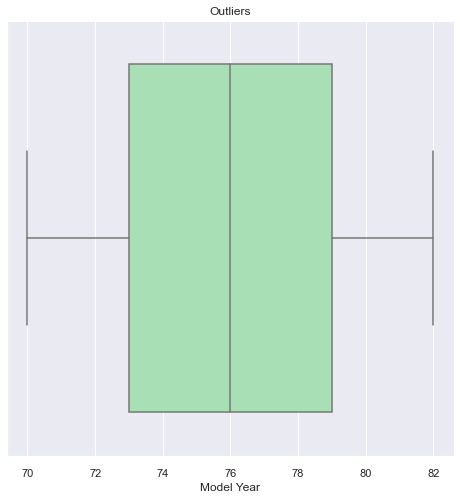

In [84]:
plt.figure(figsize=(8,8))
sns.set_palette(sns.color_palette(["#A0E8AF"]))
sns.boxplot(x=dataset['Model Year']).set(title='Outliers')
plt.show()

In [75]:
dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'Origin'],
      dtype='object')

/home/jesusarguelles/miniconda3/envs/gcp/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NameError: name 'i' is not defined

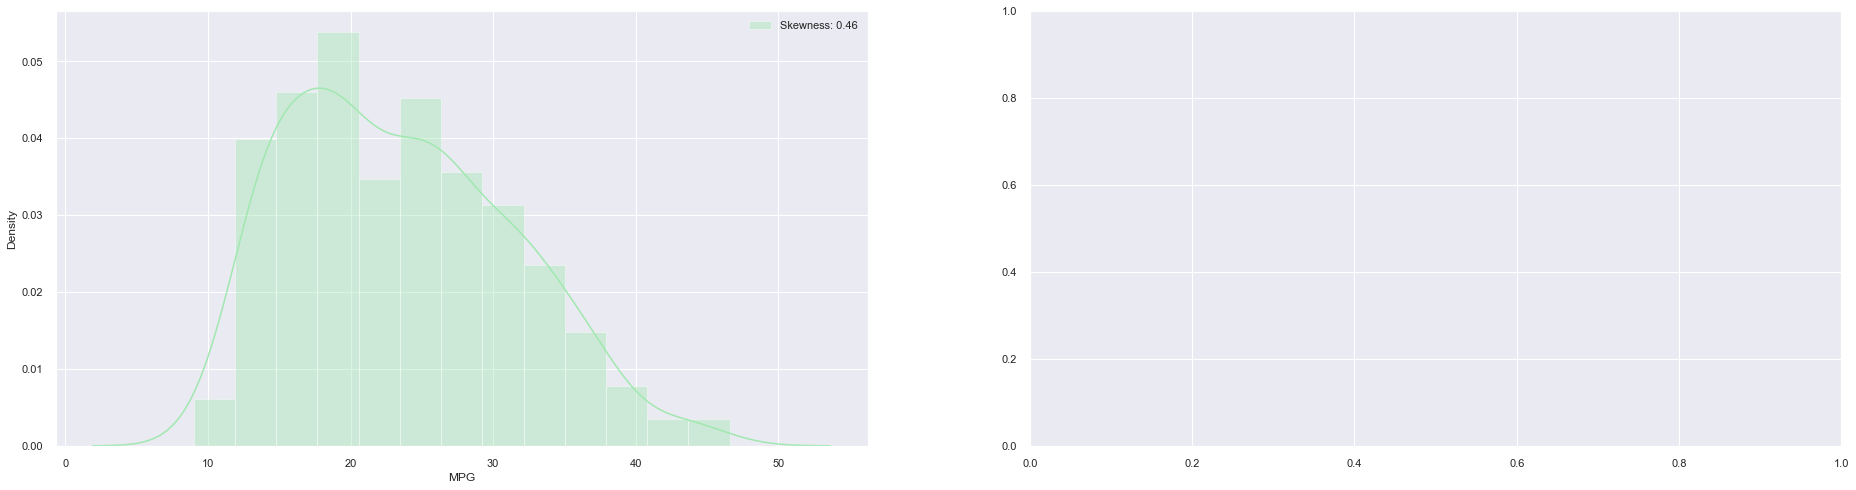

In [32]:
plt.figure(figsize=(32,8))
plt.subplot(1,2,1)
t=sns.distplot(dataset["MPG"],label="Skewness: %.2f"%(dataset["MPG"].skew()) )
t.legend()
plt.subplot(1,2,2)
sns.set_palette(sns.color_palette(["#A0E8AF"]))
sns.boxplot(x=dataset[i])
plt.show()

In [89]:
dataset.iloc[:,1:].head(20)

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,8,307.0,130.0,3504.0,12.0,70,1
1,8,350.0,165.0,3693.0,11.5,70,1
2,8,318.0,150.0,3436.0,11.0,70,1
3,8,304.0,150.0,3433.0,12.0,70,1
4,8,302.0,140.0,3449.0,10.5,70,1
5,8,429.0,198.0,4341.0,10.0,70,1
6,8,454.0,220.0,4354.0,9.0,70,1
7,8,440.0,215.0,4312.0,8.5,70,1
8,8,455.0,225.0,4425.0,10.0,70,1
9,8,390.0,190.0,3850.0,8.5,70,1


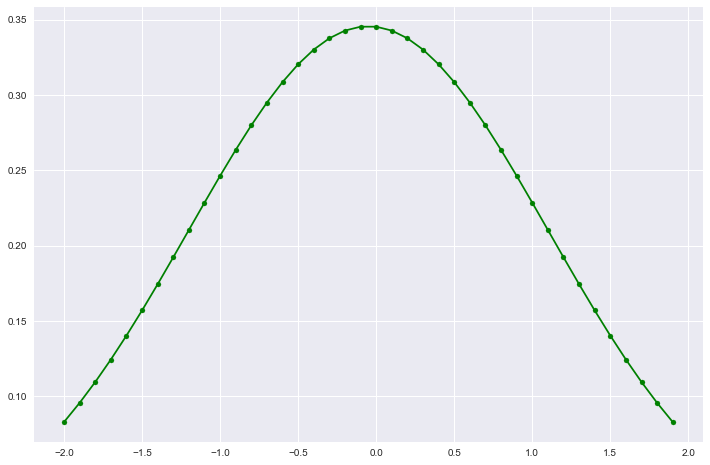

In [13]:

# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
  
# A custom function to calculate
# probability distribution function
def pdf(x):
    mean = np.mean(x)
    std = np.std(x)
    y_out = 1/(std * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * std**2))
    return y_out
    
# To generate an array of x-values
x = np.arange(-2, 2, 0.1)
  
# To generate an array of
# y-values using corresponding x-values
y = pdf(x)
  
# Plotting the bell-shaped curve
plt.style.use('seaborn')
plt.figure(figsize = (12, 8))
plt.plot(x, y, color = 'green')
  
plt.scatter( x, y, marker = 'o', s = 25, color = 'green')
plt.show()

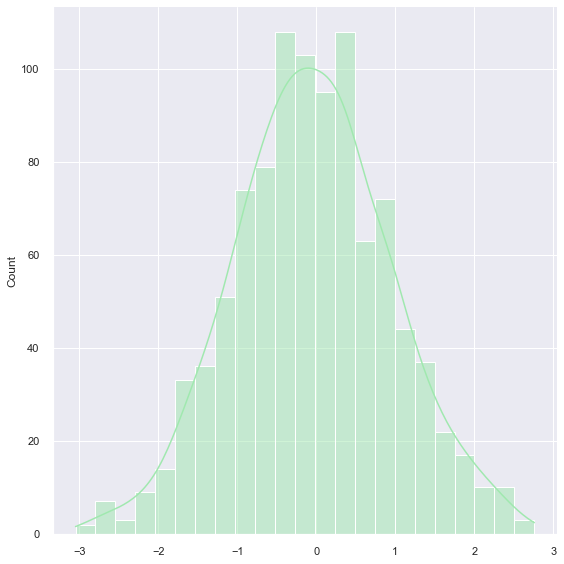

In [27]:
#plt.figure(figsize=(24,8))
np.random.seed(0)
x = np.random.normal(size=1000)
sns.set_palette(sns.color_palette(["#A0E8AF"]))
sns.displot(x, kde=True, height=8)
plt.show()